In [1]:
%reload_ext autoreload
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns


import math


import cPickle as pickle

import datetime




from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/")


/scratch/cluster/lty/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def gen_bin_classify_data_MNIST(dig1, dig0, mnist):
    cond_train = np.logical_or(mnist.train.labels == dig1, mnist.train.labels == dig0)
    
    Xtrain = mnist.train.images[cond_train, :]
    Ytrain = np.array(mnist.train.labels[cond_train] == dig1, dtype=np.float)
    
    cond_test = np.logical_or(mnist.test.labels == dig1, mnist.test.labels == dig0)
    
    Xtest = mnist.test.images[cond_test, :]
    Ytest = np.array(mnist.test.labels[cond_test] == dig1, dtype=np.float)
    
    return Xtrain, Ytrain, Xtest, Ytest

In [4]:
dig1 = 8
dig0 = 3

Xtrain, Ytrain, Xtest, Ytest = gen_bin_classify_data_MNIST(dig1, dig0, mnist)

In [5]:
# plt.figure()
# plt.imshow(Xtrain[5, :].reshape((28, 28)), cmap="binary", vmax=1, vmin=0)

In [6]:
import tensorflow as tf

In [7]:
ntrain, p = Xtrain.shape

train loss -- start
39.34753149815988
train loss -- end
0.22068862216225446


<IPython.core.display.Javascript object>


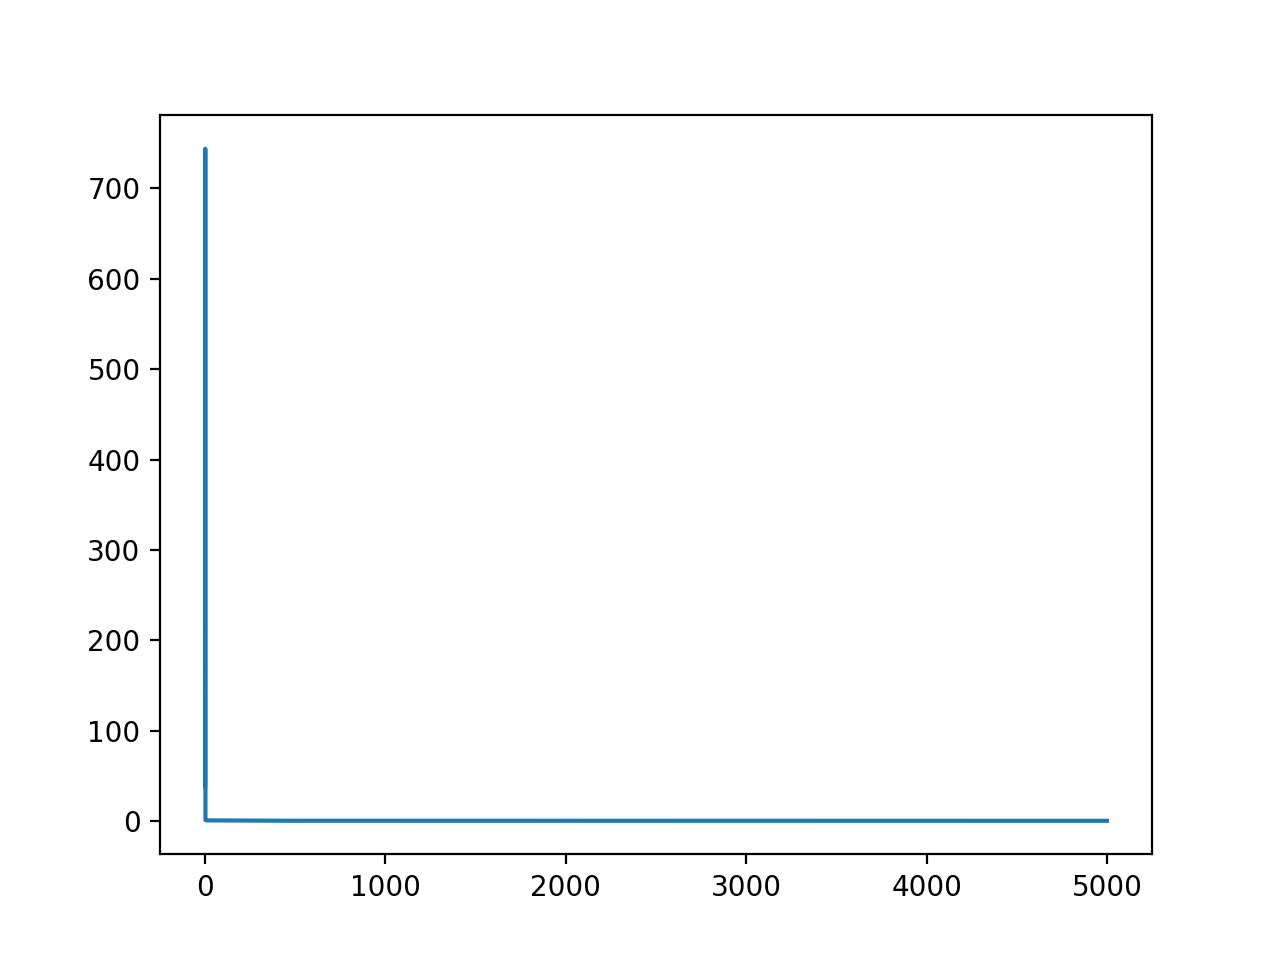

In [8]:

from __future__ import division



X = tf.placeholder(dtype=tf.float64, shape=[None, p])

Y = tf.placeholder(dtype=tf.float64, shape=[None, 1])

layers = []

layer_neuron_count = [80, 8]

K_LASSO_LAMBDA_SCALE = 1.2

lasso_lambda_layer = [K_LASSO_LAMBDA_SCALE * math.sqrt(math.log(p) / ntrain)]


for i in xrange(len(layer_neuron_count) - 1):
    lnc_in = layer_neuron_count[i] 
    lnc_out = layer_neuron_count[i + 1]
    lasso_lambda_layer.append(K_LASSO_LAMBDA_SCALE * math.sqrt(math.log(lnc_in * lnc_out) / ntrain))

layer_input = X

lnc_in = p

for lnc_out in layer_neuron_count:
    w = tf.Variable(tf.random_normal([lnc_in, lnc_out], dtype=tf.float64))
    b = tf.Variable(tf.random_normal([lnc_out], dtype=tf.float64))
    layer_output = tf.nn.softplus(tf.matmul(layer_input, w) + b)
    layers.append([w, b])
    layer_input = layer_output
    lnc_in = lnc_out

w_logistic = tf.Variable(tf.random_normal([lnc_in, 1], dtype=tf.float64))
b_logistic = tf.Variable(tf.random_normal([1], dtype=tf.float64))

y_logistic = tf.matmul(layer_input, w_logistic) + b_logistic



loss = tf.reduce_mean(tf.multiply(tf.nn.softplus(-y_logistic) - tf.nn.softplus(y_logistic), Y) + tf.nn.softplus(y_logistic))


lasso_lambda_logistic = K_LASSO_LAMBDA_SCALE * math.sqrt(math.log(lnc_in) / ntrain)


opt = tf.train.GradientDescentOptimizer(-1.0)


eta_step = .1


def lasso_prox(ts_, prox_):
    ts_prox_ = tf.constant([prox_], dtype=tf.float64)
    return tf.nn.relu(ts_ - ts_prox_) - tf.nn.relu(-ts_ - ts_prox_)


grads_and_vars = opt.compute_gradients(loss, [w_logistic, b_logistic])


apply_grads = []


# *_logistic
for gv in grads_and_vars:
    grad, var = gv
    prox = lasso_prox(var - eta_step * grad, lasso_lambda_logistic * eta_step)
    apply_grads.append((prox - var, var))

for i in xrange(len(layers)):
    wb = layers[i]
    ll = lasso_lambda_layer[i]
    grads_and_vars = opt.compute_gradients(loss, wb)
    for gv in grads_and_vars:
        grad, var = gv
        prox = lasso_prox(var - eta_step * grad, ll * eta_step)
        apply_grads.append((prox - var, var))


train_op = opt.apply_gradients(apply_grads)  

num_train_iter = 5000    

loss_train = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print "train loss -- start"
    print sess.run(loss, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})
    
    for _ in xrange(num_train_iter):
        Yrand = np.random.binomial(1, .5, size=(ntrain, 1))
        _, loss_val = sess.run([train_op, loss], feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})
        loss_train.append(loss_val)
        
        
    
    print "train loss -- end"
    print sess.run(loss, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})
        
        
plt.figure()
plt.plot(loss_train)